In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


1.11.0+cu113
     |████████████████████████████████| 7.9 MB 2.7 MB/s 
     |████████████████████████████████| 3.5 MB 3.6 MB/s 


In [2]:
pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 5.1 MB/s 
     |████████████████████████████████| 22.7 MB 1.4 MB/s 


In [25]:
import torch
import pandas as pd
import numpy as np
import torch_geometric.transforms as T
import torch_geometric
from torch_geometric.data import Dataset
import numpy as np 
import os
import deepchem as dc
import torch.nn as nn
from torch.nn import Linear,BatchNorm1d
from torch_geometric.nn import GCNConv,GATConv
from torch_geometric.nn import BatchNorm
from tqdm import tqdm
from torch_geometric.data import DataLoader
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
import seaborn as sns
import pandas as pd 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import math
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd

data = pd.read_csv('raw/totalData.csv')

data.head() 

,Unnamed: 0,Drug1_ID,Drug1_SMILES
0,0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1
1,1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl
2,2,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...
3,3,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1
4,4,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12


In [5]:


print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

remove = []

class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        self.sz = 0
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        count = 0
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            # Featurize molecule
            if type(mol["Drug1_SMILES"])==float:
              remove.append(mol["Drug1_ID"])
              continue
            f = featurizer.featurize(mol["Drug1_SMILES"])
            if not f : 
              remove.append(mol["Drug1_ID"])
              print(count)
              continue
            data = f[0].to_pyg_graph()
            data.y = 1
            data.smiles = mol["Drug1_SMILES"]
            data.id = mol["Drug1_ID"]
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                f'data_test_{count}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                f'data_{count}.pt'))
            count+=1
        self.sz = count

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.sz
        #return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data

encoder_set = MoleculeDataset("","totalData.csv")

Processing...


Torch version: 1.11.0+cu113
Cuda available: True
Torch geometric version: 2.0.5


  1%|          | 60/10951 [00:00<01:38, 110.02it/s]Failed to featurize datapoint 0, [Mg+2].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  1%|          | 72/10951 [00:00<01:48, 99.99it/s] Failed to featurize datapoint 0, [Gd+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  1%|          | 83/10951 [00:00<01:52, 96.32it/s]

68
76


  1%|▏         | 147/10951 [00:02<02:38, 68.27it/s]Failed to featurize datapoint 0, [81Kr]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  1%|▏         | 157/10951 [00:02<02:34, 69.83it/s]Failed to featurize datapoint 0, [Li+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  2%|▏         | 169/10951 [00:02<02:14, 80.29it/s]

149
163


  3%|▎         | 344/10951 [00:05<01:49, 96.83it/s]Failed to featurize datapoint 0, [Al+3].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  3%|▎         | 366/10951 [00:05<01:53, 93.62it/s] 

349


  4%|▍         | 419/10951 [00:05<01:41, 104.16it/s]Failed to featurize datapoint 0, [I-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  4%|▍         | 430/10951 [00:06<01:55, 91.47it/s] Failed to featurize datapoint 0, [Sb+5]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


420
427


  4%|▍         | 492/10951 [00:07<03:13, 53.93it/s]Failed to featurize datapoint 0, [Cr+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  5%|▍         | 505/10951 [00:07<03:10, 54.87it/s]

491


  5%|▌         | 597/10951 [00:09<04:01, 42.83it/s]Failed to featurize datapoint 0, [Fe]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  5%|▌         | 602/10951 [00:09<04:07, 41.84it/s]

590


  6%|▌         | 635/10951 [00:10<05:11, 33.15it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Mg+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  6%|▌         | 648/10951 [00:10<04:04, 42.06it/s]

629


  8%|▊         | 919/10951 [00:18<07:43, 21.62it/s]Failed to featurize datapoint 0, [Mg+2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  8%|▊         | 925/10951 [00:19<07:43, 21.61it/s]

911


  9%|▊         | 943/10951 [00:19<04:40, 35.74it/s]Failed to featurize datapoint 0, [13NH3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  9%|▊         | 949/10951 [00:19<04:06, 40.56it/s]

934


  9%|▉         | 1017/10951 [00:22<06:26, 25.71it/s]Failed to featurize datapoint 0, [Zn+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  9%|▉         | 1026/10951 [00:22<05:40, 29.18it/s]

1008


 11%|█         | 1214/10951 [00:27<04:05, 39.70it/s]Failed to featurize datapoint 0, [I-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 11%|█         | 1228/10951 [00:27<03:18, 48.90it/s]

1205


 11%|█▏        | 1236/10951 [00:28<03:08, 51.63it/s]Failed to featurize datapoint 0, [131I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 11%|█▏        | 1242/10951 [00:28<03:22, 48.00it/s]

1224


 12%|█▏        | 1285/10951 [00:29<03:45, 42.91it/s]Failed to featurize datapoint 0, [Cl-].[NH4+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 12%|█▏        | 1296/10951 [00:29<03:29, 46.07it/s]

1271


 12%|█▏        | 1316/10951 [00:30<03:57, 40.56it/s]Failed to featurize datapoint 0, [89Sr+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 12%|█▏        | 1326/10951 [00:30<04:26, 36.17it/s]

1304


 14%|█▍        | 1523/10951 [00:34<02:05, 74.91it/s]Failed to featurize datapoint 0, [3He]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 14%|█▍        | 1546/10951 [00:35<01:55, 81.18it/s]

1518


 14%|█▍        | 1558/10951 [00:35<01:44, 89.67it/s]Failed to featurize datapoint 0, [Cl-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 14%|█▍        | 1571/10951 [00:35<01:35, 97.77it/s]Failed to featurize datapoint 0, [La+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [Zn]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 14%|█▍        | 1582/10951 [00:35<01:43, 90.47it/s]

1545
1554
1554


 15%|█▌        | 1671/10951 [00:38<06:35, 23.49it/s]Failed to featurize datapoint 0, [Co]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 15%|█▌        | 1690/10951 [00:38<04:30, 34.29it/s]

1656


 17%|█▋        | 1823/10951 [00:40<02:20, 64.85it/s]Failed to featurize datapoint 0, O.O.O.O.[98Tc-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 17%|█▋        | 1845/10951 [00:40<01:51, 81.47it/s]

1811


 18%|█▊        | 1931/10951 [00:41<01:45, 85.82it/s]Failed to featurize datapoint 0, [Na+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 18%|█▊        | 1941/10951 [00:41<02:07, 70.61it/s]

1913


 18%|█▊        | 1959/10951 [00:41<01:56, 76.90it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Sn+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 18%|█▊        | 1980/10951 [00:41<01:45, 84.65it/s]Failed to featurize datapoint 0, [Mg+2].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity


1942
1961


 19%|█▉        | 2133/10951 [00:43<01:19, 111.58it/s]Failed to featurize datapoint 0, O. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 20%|█▉        | 2157/10951 [00:43<01:24, 104.23it/s]

2116


 24%|██▍       | 2664/10951 [00:49<01:22, 100.52it/s]Failed to featurize datapoint 0, [89Sr+2].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 25%|██▍       | 2685/10951 [00:49<01:24, 98.21it/s]

2643


 26%|██▌       | 2813/10951 [00:50<01:22, 98.71it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Zn+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 26%|██▌       | 2823/10951 [00:50<01:24, 96.06it/s]Failed to featurize datapoint 0, [Pt]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|██▌       | 2834/10951 [00:50<01:22, 98.03it/s]

2788
2795


Failed to featurize datapoint 0, [223Ra+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|██▌       | 2844/10951 [00:50<01:24, 96.06it/s]Failed to featurize datapoint 0, [67Ga+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|██▌       | 2855/10951 [00:51<01:21, 99.84it/s]

2811
2815


 26%|██▋       | 2876/10951 [00:51<01:25, 94.47it/s]Failed to featurize datapoint 0, [Ne]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|██▋       | 2887/10951 [00:51<01:29, 90.31it/s]

2848


 29%|██▊       | 3143/10951 [00:54<01:32, 84.22it/s]Failed to featurize datapoint 0, [32PH3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 29%|██▉       | 3156/10951 [00:54<01:21, 95.65it/s]Failed to featurize datapoint 0, [K+].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 29%|██▉       | 3168/10951 [00:54<01:17, 101.06it/s]

3111
3128


 30%|██▉       | 3236/10951 [00:55<01:15, 101.72it/s]Failed to featurize datapoint 0, [Ac]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 30%|██▉       | 3248/10951 [00:55<01:13, 105.18it/s]Failed to featurize datapoint 0, F. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 30%|██▉       | 3259/10951 [00:55<01:14, 103.62it/s]

3212
3222


 30%|███       | 3293/10951 [00:55<01:19, 96.34it/s] Failed to featurize datapoint 0, [Al+3].[Al+3].[O-2].[O-2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 30%|███       | 3303/10951 [00:55<01:32, 83.05it/s]

3258


 30%|███       | 3312/10951 [00:55<01:30, 84.22it/s]Failed to featurize datapoint 0, [Cl-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 30%|███       | 3334/10951 [00:56<01:38, 77.64it/s]

3283


 32%|███▏      | 3479/10951 [00:57<01:20, 92.49it/s]Failed to featurize datapoint 0, [Ag+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 32%|███▏      | 3489/10951 [00:58<01:22, 90.39it/s]

3444


 33%|███▎      | 3579/10951 [00:59<01:25, 86.13it/s]Failed to featurize datapoint 0, [Ca+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 33%|███▎      | 3602/10951 [00:59<01:19, 92.03it/s]Failed to featurize datapoint 0, [Cl-].[NH4+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity


3546
3563


 34%|███▍      | 3773/10951 [01:01<01:34, 75.65it/s]Failed to featurize datapoint 0, [Al+3].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 35%|███▍      | 3784/10951 [01:01<01:26, 83.07it/s]Failed to featurize datapoint 0, [Ca+2].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 35%|███▍      | 3796/10951 [01:01<01:17, 91.82it/s]

3733
3741


 35%|███▍      | 3831/10951 [01:02<01:15, 94.34it/s]Failed to featurize datapoint 0, [Ta]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 35%|███▌      | 3841/10951 [01:02<01:17, 92.29it/s]Failed to featurize datapoint 0, [Bk]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


3787
3802


 36%|███▋      | 3980/10951 [01:03<01:13, 94.97it/s]Failed to featurize datapoint 0, [Li+].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 37%|███▋      | 4000/10951 [01:04<01:20, 86.58it/s]

3940


 37%|███▋      | 4044/10951 [01:04<01:51, 62.05it/s]Failed to featurize datapoint 0, [Ti]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 37%|███▋      | 4060/10951 [01:05<02:29, 46.15it/s]

4000


Failed to featurize datapoint 0, [Co+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 37%|███▋      | 4079/10951 [01:05<01:50, 62.43it/s]

4015


 38%|███▊      | 4152/10951 [01:06<01:18, 86.68it/s]Failed to featurize datapoint 0, [Fe]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 38%|███▊      | 4172/10951 [01:06<01:21, 82.74it/s]

4108


 38%|███▊      | 4181/10951 [01:06<01:21, 82.63it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Cl-].[Cr+3]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 38%|███▊      | 4204/10951 [01:06<01:09, 96.94it/s]

4138


 39%|███▉      | 4245/10951 [01:07<01:22, 81.36it/s]Failed to featurize datapoint 0, [99Tc]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 39%|███▉      | 4268/10951 [01:07<01:21, 82.24it/s]

4206


 41%|████      | 4440/10951 [01:10<01:22, 79.03it/s]Failed to featurize datapoint 0, [131I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 41%|████      | 4461/10951 [01:10<01:11, 90.57it/s]

4395


 41%|████      | 4499/10951 [01:10<01:17, 82.78it/s]Failed to featurize datapoint 0, [Ba]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [Mo]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 41%|████▏     | 4518/10951 [01:10<01:15, 84.89it/s]

4452
4453


 43%|████▎     | 4725/10951 [01:13<01:31, 68.26it/s]Failed to featurize datapoint 0, [Cd]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


4676


 43%|████▎     | 4749/10951 [01:13<01:49, 56.43it/s]Failed to featurize datapoint 0, [123I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 44%|████▎     | 4773/10951 [01:14<01:21, 76.16it/s]

4703


 45%|████▌     | 4954/10951 [01:16<01:10, 85.14it/s]Failed to featurize datapoint 0, [P]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 45%|████▌     | 4975/10951 [01:16<01:06, 89.72it/s]

4899


 46%|████▌     | 5018/10951 [01:17<01:06, 89.12it/s]Failed to featurize datapoint 0, [Li+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 46%|████▌     | 5040/10951 [01:17<01:00, 96.98it/s]

4962


 46%|████▌     | 5051/10951 [01:17<01:12, 80.86it/s]Failed to featurize datapoint 0, [OH-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 46%|████▋     | 5073/10951 [01:17<01:03, 92.36it/s]

4994


 47%|████▋     | 5197/10951 [01:19<01:04, 89.06it/s]Failed to featurize datapoint 0, [Se]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 48%|████▊     | 5219/10951 [01:19<00:59, 96.61it/s]

5143


 48%|████▊     | 5258/10951 [01:19<01:10, 80.89it/s]Failed to featurize datapoint 0, [I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 48%|████▊     | 5278/10951 [01:20<01:03, 89.47it/s]

5201


 49%|████▉     | 5355/10951 [01:20<00:56, 99.25it/s] Failed to featurize datapoint 0, [Cl-].[Tl+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 49%|████▉     | 5366/10951 [01:21<01:02, 88.70it/s]Failed to featurize datapoint 0, [18F]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 49%|████▉     | 5379/10951 [01:21<00:56, 99.25it/s]

5296
5312


 50%|████▉     | 5446/10951 [01:21<00:57, 95.52it/s]Failed to featurize datapoint 0, [V]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 50%|████▉     | 5467/10951 [01:22<00:57, 96.14it/s]

5385


Failed to featurize datapoint 0, [82Rb+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 50%|█████     | 5477/10951 [01:22<01:03, 85.88it/s]

5406


 51%|█████     | 5548/10951 [01:23<01:07, 79.70it/s]Failed to featurize datapoint 0, [Cl-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
Failed to featurize datapoint 0, [51Cr]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 51%|█████     | 5573/10951 [01:23<00:55, 97.51it/s]

5487
5491


 51%|█████     | 5584/10951 [01:23<00:54, 98.33it/s]Failed to featurize datapoint 0, [Sb]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 51%|█████     | 5596/10951 [01:23<00:51, 103.34it/s]Failed to featurize datapoint 0, [177Lu]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 51%|█████     | 5609/10951 [01:23<00:48, 110.63it/s]

5526
5533


 52%|█████▏    | 5668/10951 [01:24<00:51, 102.65it/s]Failed to featurize datapoint 0, [C]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 52%|█████▏    | 5679/10951 [01:24<00:52, 101.18it/s]

5604


 52%|█████▏    | 5701/10951 [01:24<00:56, 92.11it/s]Failed to featurize datapoint 0, [Rb]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 52%|█████▏    | 5726/10951 [01:24<00:49, 104.96it/s]

5640


 53%|█████▎    | 5800/10951 [01:25<00:51, 100.19it/s]Failed to featurize datapoint 0, [Zn]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 53%|█████▎    | 5824/10951 [01:25<00:49, 103.61it/s]

5729


 56%|█████▋    | 6182/10951 [01:32<01:31, 52.01it/s]Failed to featurize datapoint 0, [Fe+3].[O-2].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 57%|█████▋    | 6205/10951 [01:33<01:05, 73.00it/s]

6112


 59%|█████▉    | 6495/10951 [01:41<01:29, 49.74it/s]Failed to featurize datapoint 0, [90Y]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 59%|█████▉    | 6504/10951 [01:41<01:24, 52.38it/s]

6422


 60%|█████▉    | 6552/10951 [01:42<01:03, 69.15it/s]Failed to featurize datapoint 0, O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.[Mo].[Mo].[Mo].[Mo].[Mo].[Mo].[Mo].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 60%|██████    | 6572/10951 [01:42<00:54, 79.89it/s]

6479


Failed to featurize datapoint 0, [153Sm]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 60%|██████    | 6590/10951 [01:42<00:55, 79.14it/s]

6502


 62%|██████▏   | 6781/10951 [01:46<00:38, 107.76it/s]Failed to featurize datapoint 0, [Cr]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 62%|██████▏   | 6793/10951 [01:46<00:40, 102.52it/s]Failed to featurize datapoint 0, [Na+].[Na+].[S-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 62%|██████▏   | 6805/10951 [01:46<00:38, 106.98it/s]

6707
6717


 63%|██████▎   | 6849/10951 [01:46<00:44, 92.55it/s]Failed to featurize datapoint 0, [201Tl+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 63%|██████▎   | 6871/10951 [01:47<00:46, 88.53it/s]

6776


 65%|██████▌   | 7126/10951 [01:49<01:01, 62.65it/s]Failed to featurize datapoint 0, [B]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 65%|██████▌   | 7142/10951 [01:50<00:57, 65.79it/s]

7050


 65%|██████▌   | 7155/10951 [01:50<00:47, 79.37it/s]Failed to featurize datapoint 0, O.[Al+3].[Al+3].[Cl-].[OH-].[OH-].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 66%|██████▌   | 7175/10951 [01:50<00:45, 83.39it/s]

7079


 67%|██████▋   | 7309/10951 [01:51<00:38, 94.46it/s]Failed to featurize datapoint 0, [Mg+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 67%|██████▋   | 7319/10951 [01:52<00:38, 95.18it/s]

7229


 67%|██████▋   | 7340/10951 [01:52<00:40, 89.54it/s]Failed to featurize datapoint 0, Br.Br.Br.Br.Br.Br.Br.Br.Br.Br.Br.[Br-].[Ta+].[Ta].[Ta].[Ta].[Ta].[Ta]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 67%|██████▋   | 7350/10951 [01:52<00:39, 90.20it/s]

7261


 68%|██████▊   | 7410/10951 [01:53<00:42, 84.16it/s]Failed to featurize datapoint 0, [Fe+2].[Fe+3].[Fe+3].[O-2].[O-2].[O-2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 68%|██████▊   | 7431/10951 [01:53<00:39, 90.02it/s]

7329


 68%|██████▊   | 7451/10951 [01:53<00:41, 84.22it/s]Failed to featurize datapoint 0, [Ca+2].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 68%|██████▊   | 7460/10951 [01:53<00:41, 85.09it/s]

7370


 69%|██████▊   | 7518/10951 [01:58<04:03, 14.12it/s]Failed to featurize datapoint 0, [Al]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 69%|██████▉   | 7539/10951 [01:59<02:10, 26.11it/s]

7432


 69%|██████▉   | 7548/10951 [01:59<01:46, 32.07it/s]Failed to featurize datapoint 0, [Mn+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 69%|██████▉   | 7568/10951 [01:59<01:07, 49.77it/s]

7466


 69%|██████▉   | 7588/10951 [01:59<00:51, 64.91it/s]Failed to featurize datapoint 0, [223Ra]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 69%|██████▉   | 7598/10951 [01:59<00:46, 71.59it/s]

7507


 71%|███████   | 7735/10951 [02:01<00:37, 84.69it/s]Failed to featurize datapoint 0, [I-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 71%|███████   | 7745/10951 [02:01<00:37, 85.11it/s]

7646


 72%|███████▏  | 7845/10951 [02:03<00:49, 63.01it/s]Failed to featurize datapoint 0, [Ag]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 72%|███████▏  | 7867/10951 [02:03<00:41, 74.81it/s]

7758


 76%|███████▌  | 8272/10951 [02:08<00:34, 76.82it/s]Failed to featurize datapoint 0, [C]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 76%|███████▌  | 8290/10951 [02:09<00:35, 75.45it/s]

8184


 76%|███████▌  | 8341/10951 [02:09<00:31, 83.12it/s]Failed to featurize datapoint 0, [Si]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 76%|███████▋  | 8361/10951 [02:09<00:28, 89.86it/s]

8251


 76%|███████▋  | 8371/10951 [02:09<00:31, 82.72it/s]Failed to featurize datapoint 0, O.O.O.O.[Al+3].[Mg+2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[OH-].[Si+4].[Si+4].[Si+4].[Si+4]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 77%|███████▋  | 8393/10951 [02:10<00:30, 84.25it/s]

8289


 77%|███████▋  | 8449/10951 [02:10<00:28, 86.83it/s]Failed to featurize datapoint 0, [Bi+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 77%|███████▋  | 8461/10951 [02:10<00:26, 95.68it/s]

8357


 77%|███████▋  | 8471/10951 [02:11<00:28, 86.79it/s]Failed to featurize datapoint 0, [Cl-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 78%|███████▊  | 8495/10951 [02:11<00:24, 99.49it/s]

8383


 78%|███████▊  | 8544/10951 [02:11<00:24, 97.52it/s]Failed to featurize datapoint 0, [F-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 78%|███████▊  | 8565/10951 [02:12<00:29, 81.75it/s]

8456


 79%|███████▊  | 8608/10951 [02:12<00:23, 97.96it/s]Failed to featurize datapoint 0, [F-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 79%|███████▉  | 8632/10951 [02:12<00:22, 104.33it/s]

8520


 80%|████████  | 8783/10951 [02:14<00:29, 72.97it/s]Failed to featurize datapoint 0, [KH]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 80%|████████  | 8804/10951 [02:14<00:24, 86.22it/s]

8687


 83%|████████▎ | 9044/10951 [02:17<00:20, 91.49it/s]Failed to featurize datapoint 0, [Cu+2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 83%|████████▎ | 9064/10951 [02:17<00:20, 91.95it/s]

8954


 83%|████████▎ | 9096/10951 [02:18<00:18, 97.94it/s]Failed to featurize datapoint 0, [Al+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 83%|████████▎ | 9117/10951 [02:18<00:19, 92.65it/s]

9001


 84%|████████▎ | 9166/10951 [02:18<00:22, 80.52it/s]Failed to featurize datapoint 0, [Cu]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 84%|████████▍ | 9185/10951 [02:19<00:22, 79.04it/s]Failed to featurize datapoint 0, [MgH2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


9073
9087


 86%|████████▌ | 9393/10951 [02:21<00:14, 105.52it/s]Failed to featurize datapoint 0, [Fe+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 86%|████████▌ | 9415/10951 [02:21<00:15, 101.55it/s]

9293


 87%|████████▋ | 9501/10951 [02:22<00:16, 89.79it/s]Failed to featurize datapoint 0, [Cu+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 87%|████████▋ | 9522/10951 [02:22<00:15, 94.59it/s]

9399


 87%|████████▋ | 9532/10951 [02:23<00:16, 83.94it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Co+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 87%|████████▋ | 9557/10951 [02:23<00:14, 99.14it/s]Failed to featurize datapoint 0, [Nb]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


9436
9454


 88%|████████▊ | 9590/10951 [02:23<00:14, 96.90it/s]Failed to featurize datapoint 0, [Au]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 88%|████████▊ | 9612/10951 [02:23<00:13, 101.70it/s]

9485


 88%|████████▊ | 9643/10951 [02:24<00:14, 88.59it/s]Failed to featurize datapoint 0, [133Xe]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 88%|████████▊ | 9671/10951 [02:24<00:12, 103.47it/s]

9541


 89%|████████▉ | 9776/10951 [02:25<00:12, 96.15it/s]Failed to featurize datapoint 0, [Sm]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 89%|████████▉ | 9795/10951 [02:25<00:15, 73.60it/s]

9669


 90%|████████▉ | 9813/10951 [02:26<00:14, 80.29it/s]Failed to featurize datapoint 0, [Na+].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 90%|████████▉ | 9832/10951 [02:26<00:14, 78.85it/s]

9709


 91%|█████████ | 9962/10951 [02:27<00:12, 76.18it/s]Failed to featurize datapoint 0, [He]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 91%|█████████ | 9971/10951 [02:27<00:12, 78.93it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Mg+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
Failed to featurize datapoint 0, [Mg+2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 91%|█████████ | 9982/10951 [02:27<00:11, 84.91it/s]

9857
9864
9866


 93%|█████████▎| 10149/10951 [02:29<00:08, 92.13it/s]Failed to featurize datapoint 0, [Fe+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 93%|█████████▎| 10169/10951 [02:29<00:08, 90.81it/s]

10038


 93%|█████████▎| 10192/10951 [02:30<00:07, 101.37it/s]Failed to featurize datapoint 0, [111In+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [67Ga+3].[Cl-].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 93%|█████████▎| 10204/10951 [02:30<00:08, 92.27it/s] 

10077
10082


 93%|█████████▎| 10214/10951 [02:30<00:08, 84.50it/s]Failed to featurize datapoint 0, [Ni+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [Se]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 93%|█████████▎| 10234/10951 [02:30<00:08, 86.53it/s]

10101
10103


 94%|█████████▎| 10254/10951 [02:30<00:07, 92.05it/s]Failed to featurize datapoint 0, [Ca]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 94%|█████████▍| 10274/10951 [02:31<00:07, 89.87it/s]Failed to featurize datapoint 0, [K+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


10138
10154


 95%|█████████▌| 10409/10951 [02:32<00:08, 60.41it/s]Failed to featurize datapoint 0, [Ga+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 95%|█████████▌| 10430/10951 [02:33<00:06, 77.45it/s]

10295


 95%|█████████▌| 10441/10951 [02:33<00:06, 83.74it/s]Failed to featurize datapoint 0, [Gd]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 96%|█████████▌| 10459/10951 [02:33<00:08, 59.12it/s]

10328


 96%|█████████▌| 10490/10951 [02:33<00:05, 81.31it/s]Failed to featurize datapoint 0, O.O.O.O.[Mo+6].[Mo+6].[Mo+6].[Mo+6].[Mo+6].[Mo+6].[Mo+6].[NH4+].[NH4+].[NH4+].[NH4+].[NH4+].[NH4+].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 96%|█████████▌| 10500/10951 [02:34<00:05, 85.19it/s]Failed to featurize datapoint 0, [Mg+2].[O-2].[O-2].[O-2].[Si+4]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 96%|█████████▌| 10510/10951 [02:34<00:05, 87.17it/s]

10370
10383


 97%|█████████▋| 10652/10951 [02:35<00:03, 81.00it/s]Failed to featurize datapoint 0, [18F-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 97%|█████████▋| 10676/10951 [02:36<00:02, 97.71it/s]

10529


 98%|█████████▊| 10751/10951 [02:36<00:02, 74.16it/s]Failed to featurize datapoint 0, [Au+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 98%|█████████▊| 10764/10951 [02:37<00:02, 86.16it/s]

10627


 99%|█████████▉| 10834/10951 [02:37<00:01, 83.24it/s]Failed to featurize datapoint 0, [In]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 99%|█████████▉| 10846/10951 [02:38<00:01, 92.13it/s]

10718


100%|█████████▉| 10898/10951 [02:38<00:00, 85.70it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Sr+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
100%|█████████▉| 10908/10951 [02:38<00:00, 88.97it/s]Failed to featurize datapoint 0, [111In]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


10778
10782


100%|█████████▉| 10918/10951 [02:39<00:00, 69.44it/s]Failed to featurize datapoint 0, [Cl-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
100%|█████████▉| 10929/10951 [02:39<00:00, 77.90it/s]

10789


100%|██████████| 10951/10951 [02:40<00:00, 68.35it/s]
Done!


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
class GVAE(nn.Module):
    def __init__(self, feature_size, edge_size):
        super(GVAE, self).__init__()
        self.encoder_embedding_size = 48
        self.feature_size = feature_size
        self.edge_dim = edge_size
        self.latent_embedding_size = 8
        self.decoder_hidden_neurons = 64
        decoder_size = 64

        # Encoder layers
        self.conv1 = GATConv(feature_size, self.encoder_embedding_size,edge_dim=self.edge_dim)
        #self.conv1 = GCNConv(feature_size, self.encoder_embedding_size)
        self.bn1 = BatchNorm(self.encoder_embedding_size)
        self.conv2 = GCNConv(self.encoder_embedding_size, self.encoder_embedding_size)
        self.bn2 = BatchNorm(self.encoder_embedding_size)
        #self.conv3 = GATConv(self.encoder_embedding_size, self.encoder_embedding_size,edge_dim=self.edge_dim)
        self.conv3 = GCNConv(self.encoder_embedding_size, self.encoder_embedding_size)
        self.bn3 = BatchNorm(self.encoder_embedding_size)

        # Latent transform layers
        self.mu_transform = Linear(self.encoder_embedding_size, 
                                            self.latent_embedding_size)
        
 
        
      
        self.decoder_dense_3 = Linear(self.latent_embedding_size, decoder_size)
        self.decoder_bn_3 = BatchNorm1d(decoder_size)
        self.decoder_dense_4 = Linear(decoder_size, self.feature_size)
        

    def encode(self, x, edge_attr, edge_index, batch_index):
        # GNN layers
        x = self.conv1(x, edge_index, edge_attr).relu()
        x = self.bn1(x)
        x = self.conv2(x, edge_index).relu()
        x = self.bn2(x)
        x = self.conv3(x, edge_index).relu()
        x = self.bn3(x)
        
        # Latent transform layers
        mu = self.mu_transform(x)
        
        return mu


    def decode(self, z, batch_index):
        x = self.decoder_dense_3(z).relu()
        x = self.decoder_bn_3(x)
        x = self.decoder_dense_4(x)
        return x


    def reparameterize(self, mu):
        return mu

    def forward(self, x, edge_attr, edge_index, batch_index):
        mu = self.encode(x, edge_attr, edge_index, batch_index)
        z = self.reparameterize(mu)
        triu_logits = self.decode(z, batch_index)

        return triu_logits, mu

    
   
model = GVAE(feature_size=encoder_set[0].x.shape[1],edge_size=encoder_set[0].edge_attr.shape[1])
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GVAE(
  (conv1): GATConv(30, 48, heads=1)
  (bn1): BatchNorm(48)
  (conv2): GCNConv(48, 48)
  (bn2): BatchNorm(48)
  (conv3): GCNConv(48, 48)
  (bn3): BatchNorm(48)
  (mu_transform): Linear(in_features=48, out_features=8, bias=True)
  (decoder_dense_3): Linear(in_features=8, out_features=64, bias=True)
  (decoder_bn_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_dense_4): Linear(in_features=64, out_features=30, bias=True)
)
Number of parameters:  10198


In [8]:
def count_parameters(model):
    """
    Counts the number of parameters for a Pytorch model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
from torch_geometric.data import DataLoader

data_size = len(encoder_set)
NUM_GRAPHS_PER_BATCH = 64
frac = 0.75
train_loader = DataLoader(encoder_set[:int(data_size * frac)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)
test_loader = DataLoader(encoder_set[int(data_size * frac):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)


model = model.to(device)


In [14]:
from torch_geometric.utils import to_dense_adj
def gvae_loss(decode_pred, edge_index, node_feats, mu, batch_index):
    # Convert target edge index to dense adjacency matrix
    batch_targets = torch.squeeze(to_dense_adj(edge_index))
    #b = fractional_matrix_power(degree, -0.5).to(device)
    batch_targets = batch_targets + torch.eye(batch_targets.shape[0]).to(device)
    degree = torch.diag(torch.sum(batch_targets, axis=1))
    dinv = torch.linalg.inv(degree)
    dinvsqrt = torch.sqrt(dinv)
    mat = torch.matmul(dinvsqrt,batch_targets)
    mat = torch.matmul(mat,dinvsqrt)
    mat = torch.matmul(mat,node_feats)
    
    # Reconstruction loss per graph
    res = mat - decode_pred
    
    ssq = (torch.diag(torch.mm(res,res.T)))
    batch_recon_loss = torch.sum(ssq)/(ssq.shape[0])

    return batch_recon_loss

In [15]:
loss_fn = gvae_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)


In [16]:

def run_one_epoch(data_loader, type, epoch):
    # Store per batch loss and accuracy 
    all_losses = []
    all_accs = []
    all_kldivs = []

    # Iterate over data loader
    for i, batch in enumerate(tqdm(data_loader)):
        # Some of the data points have invalid adjacency matrices 
        try:
            # Use GPU
            batch.to(device)  
            # Reset gradients
            optimizer.zero_grad() 
            # Call model
            decode_pred, mu = model(batch.x.float(), 
                                            batch.edge_attr.float(),
                                            batch.edge_index, 
                                            batch.batch) 
            # Calculate loss and backpropagate
            
            
            loss = loss_fn(decode_pred, batch.edge_index, batch.x.float(), mu, batch.batch)
            if type == "Train":
                loss.backward()  
                optimizer.step()  
            # Calculate metrics
            # Store loss and metrics
            all_losses.append(loss.detach().cpu().numpy())
           
            

        except IndexError as error:
            print("Error: ", error)
    
    print(f"{type} epoch {epoch} loss: ", np.array(all_losses).mean())
    

In [17]:
for epoch in range(11): 
  model.train()
  run_one_epoch(train_loader, type="Train", epoch=epoch)
  if epoch % 5 == 0:
      print("Start test epoch...")
      model.eval()
      run_one_epoch(test_loader, type="Test", epoch=epoch)

100%|██████████| 127/127 [00:10<00:00, 11.57it/s]


Train epoch 0 loss:  1.3572402
Start test epoch...


100%|██████████| 43/43 [00:02<00:00, 16.69it/s]


Test epoch 0 loss:  0.29783842


100%|██████████| 127/127 [00:08<00:00, 15.84it/s]


Train epoch 1 loss:  0.2639893


100%|██████████| 127/127 [00:07<00:00, 16.28it/s]


Train epoch 2 loss:  0.2063227


100%|██████████| 127/127 [00:07<00:00, 16.20it/s]


Train epoch 3 loss:  0.1772345


100%|██████████| 127/127 [00:07<00:00, 16.27it/s]


Train epoch 4 loss:  0.1595177


100%|██████████| 127/127 [00:08<00:00, 15.82it/s]


Train epoch 5 loss:  0.14664717
Start test epoch...


100%|██████████| 43/43 [00:02<00:00, 17.02it/s]


Test epoch 5 loss:  0.12643312


100%|██████████| 127/127 [00:07<00:00, 15.93it/s]


Train epoch 6 loss:  0.13691454


100%|██████████| 127/127 [00:07<00:00, 16.04it/s]


Train epoch 7 loss:  0.12928067


100%|██████████| 127/127 [00:08<00:00, 15.54it/s]


Train epoch 8 loss:  0.12319461


100%|██████████| 127/127 [00:07<00:00, 16.14it/s]


Train epoch 9 loss:  0.1180393


100%|██████████| 127/127 [00:08<00:00, 15.73it/s]


Train epoch 10 loss:  0.113392144
Start test epoch...


100%|██████████| 43/43 [00:03<00:00, 11.04it/s]

Test epoch 10 loss:  0.09927598


In [18]:
NUM_GRAPHS_PER_BATCH = 1
loader = DataLoader(encoder_set, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

dictval = {}
for batch in loader : 
  batch.to(device)
  decode_pred, mu = model(batch.x.float(), 
                            batch.edge_attr.float(),
                            batch.edge_index, 
                            batch.batch) 
  
  
  dictval[batch.id[0]] = mu
  
print("done!!!")
  

      

done!!!


In [20]:
temp = pd.read_csv("sup_train_val.csv")
temp.head()

,Unnamed: 0,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
0,0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,1.0
1,1,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1,0.0
2,2,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12,8290.0,N[C@@H](c1ccccc1)c1ccc(-c2ncnc3[nH]cnc23)cc1,0.0
3,3,7947.0,CCCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[...,3010.0,CNCCc1ccccn1,0.0
4,4,DB00802,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,DB00872,Cc1nc2c([nH]1)CCN(C(=O)c1ccc(NC(=O)c3ccccc3-c3...,1.0


In [21]:
df = temp

In [22]:
n_classes = len(df['label'].unique())
n_classes

2

In [23]:
dftrain = temp
dftest = pd.read_csv('sup_test.csv')

In [26]:
class NumbersDataset(Dataset):
    def __init__(self,filename):
        datat = temp
        
        self.samples = list(range(len(datat)))
        self.label = list(range(len(datat)))
        self.sz = 0
        idx = 0
        for index in range(len(datat)) :
          str1 = datat['Drug1_ID'][index]
          str2 = datat['Drug2_ID'][index]

          if (str1 in dictval) and (str2 in dictval) :
            mat1 = dictval[str1]
            mat2 = dictval[str2]
            mean1 = torch.mean(mat1, axis = 0)
            std1 = torch.std(mat1, axis = 0)
            mean2 = torch.mean(mat2, axis = 0)
            std2 = torch.std(mat2, axis = 0)
            vect = torch.cat([mean1, mean2, std1, std2], dim=0)
            self.samples[idx] = vect.detach().cpu()
            self.label[idx] = datat['label'][index]
            self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
            idx+=1
        self.sz = idx


    def __len__(self):
        return self.sz

    def __getitem__(self, idx):
        return self.samples[idx],self.label[idx]

dataset = NumbersDataset("raw/sup_train_val.csv")
len(dataset)

65075

In [27]:
import torch.nn.functional as F 
torch.manual_seed(42)

class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x
model_ff = NeuralNet(dataset[0][0].shape[0],128)
print(model_ff)
print("Number of parameters: ", sum(p.numel() for p in model_ff.parameters()))

NeuralNet(
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Number of parameters:  4482


In [28]:
data = dataset

In [29]:



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ff.parameters(), lr=0.001)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ff = model_ff.to(device)
loss_fn = loss_fn.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 128
loader = DataLoader(data,batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)



def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch[0] = batch[0].to(device) 
      batch[1] = batch[1].to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      
      pred = model_ff(batch[0]) 
      
      # Calculating the loss and gradients
      
      
      loss = (loss_fn(pred, batch[1]))      
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss

print("Starting training...")
losses = []
for epoch in range(251):
    loss = train(data)
    losses.append(loss)
    if epoch % 50 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 0.5506323575973511
Epoch 50 | Train Loss 0.5096133947372437
Epoch 100 | Train Loss 0.394612193107605
Epoch 150 | Train Loss 0.45609623193740845
Epoch 200 | Train Loss 0.4013234078884125
Epoch 250 | Train Loss 0.44898971915245056


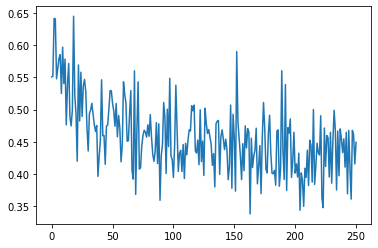

In [30]:
# Visualize learning (training loss)

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [31]:
class TestDataset(Dataset):
    def __init__(self,filename):
        datat = dftest
       
        
        self.samples = list(range(len(datat)))
        self.label = list(range(len(datat)))
        self.sz = 0
        idx = 0
        for index in range(len(datat)) :
          str1 = datat['Drug1_ID'][index]
          str2 = datat['Drug2_ID'][index]

          if (str1 in dictval) and (str2 in dictval) :
            mat1 = dictval[str1]
            mat2 = dictval[str2]
            mean1 = torch.mean(mat1, axis = 0)
            std1 = torch.std(mat1, axis = 0)
            mean2 = torch.mean(mat2, axis = 0)
            std2 = torch.std(mat2, axis = 0)
            vect = torch.cat([mean1, mean2, std1, std2], dim=0)
            self.samples[idx] = vect.detach().cpu()
            self.label[idx] = datat['label'][index]
            self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
            idx+=1
        self.sz = idx


    def __len__(self):
        return self.sz

    def __getitem__(self, idx):
        return self.samples[idx],self.label[idx]

datatest = TestDataset("raw/sup_test.csv")
len(datatest)

16234

In [32]:
test_loader = DataLoader(datatest,batch_size=len(datatest), shuffle=True)
dffull = pd.DataFrame(columns = ['y_real','y_pred'])
with torch.no_grad():
    for test_batch in test_loader : 
      test_batch[0] = test_batch[0].to(device)
      test_batch[1] = test_batch[1].to(device)
      pred = model_ff(test_batch[0]) 
      pred_frac0 = pred[:,0]
      pred_frac1 = pred[:,1]
      if n_classes == 3 : 
        pred_frac2 = pred[:,2]
      pred = pred.argmax(dim=1)  
      dftt = pd.DataFrame()
      dftt["y_real"] = test_batch[1].tolist()
      dftt["y_pred"] = pred.tolist()
      dftt["y_predfrac0"] = pred_frac0.tolist()
      dftt["y_predfrac1"] = pred_frac1.tolist()
      if n_classes == 3 : 
        dftt["y_predfrac2"] = pred_frac2.tolist()
      dffull = dffull.append(dftt)
      print(f1_score(dftt['y_real'], dftt['y_pred'],average='macro'))

dffull.to_csv('tt.csv')
dffull.tail()

0.8673412252264872


,y_real,y_pred,y_predfrac0,y_predfrac1
16229,1,0,0.713790,2.862100e-01
16230,0,0,0.999427,5.730734e-04
16231,0,0,1.000000,1.023130e-21
16232,1,1,0.363284,6.367161e-01
16233,0,0,1.000000,4.447388e-07


In [33]:
datahead = pd.read_csv('tt.csv')

print(f1_score(datahead['y_real'], datahead['y_pred'],average='macro'))
print(f1_score(datahead['y_real'], datahead['y_pred'],average='micro'))
print(accuracy_score(datahead['y_real'], datahead['y_pred']))

confusion_matrix(datahead['y_real'], datahead['y_pred'])

0.8673412252264872
0.8673771097696193
0.8673771097696193


array([[7174,  935],
       [1218, 6907]])

In [34]:
dfttt = datahead.iloc[:,3:]
dfttt.head()

,y_predfrac0,y_predfrac1
0,1.000000,1.040117e-07
1,0.989919,1.008080e-02
2,1.000000,2.074118e-07
3,1.000000,2.847760e-13
4,0.997523,2.477430e-03


In [35]:
probab = dfttt.to_numpy()

In [36]:
auc = roc_auc_score(datahead['y_real'],datahead['y_predfrac1'])
print('AUC: %.3f' % auc)

AUC: 0.918


Model: ROC AUC=0.918


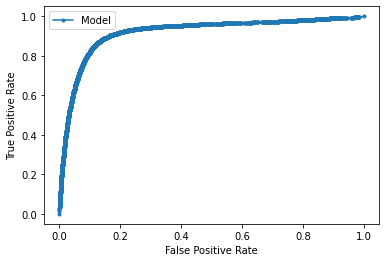

In [37]:

lr_auc = roc_auc_score(datahead['y_real'],datahead['y_predfrac1'])
# summarize scores

print('Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, _ = roc_curve(datahead['y_real'],datahead['y_predfrac1'])
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.865 auc=0.913


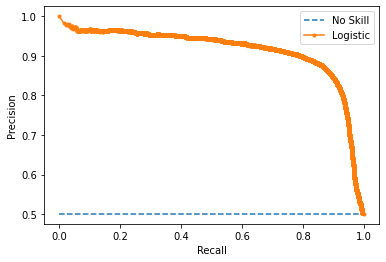

In [38]:
lr_precision, lr_recall, _ = precision_recall_curve(datahead['y_real'],datahead['y_predfrac1'])
lr_f1, lr_auc = f1_score(datahead['y_real'], datahead['y_pred']), metrics.auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(datahead['y_real'][datahead['y_real']==1]) / len(datahead['y_real'])
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()